Crystal Grpahs (CG) Construction

In [1]:
import csv, functools, json, warnings, re
import os, random
import numpy as np
import torch
from torch.utils.data import Dataset
from pymatgen.core import Element, Structure, Lattice
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

class GaussianDistance(object):
    def __init__(self, dmin, dmax, step, var=None):
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax + step, step)
        self.var = step if var is None else var

    def expand(self, distances):
        return np.exp(-(distances[..., np.newaxis] - self.filter) ** 2 / self.var ** 2)


class CIFData(Dataset):
    def __init__(self, id_prop_path, magmom_path, eigen_path, ofm_val_comp_path,
             max_num_nbr=12, radius=8, dmin=0, step=0.1, random_seed=123):


        # Load CSV
        with open(id_prop_path) as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]

        # Load magnetic moments
        with open(magmom_path) as f:
            self.magmom = json.load(f)

        # Load magnetic moments
        with open(eigen_path) as f:
            self.eigen1 = json.load(f)

        # Load magnetic moments
        with open(ofm_val_comp_path) as f:
            self.ofm_val_comp = json.load(f)

        random.seed(random_seed)
        random.shuffle(self.id_prop_data)

        self.gdf = GaussianDistance(dmin=dmin, dmax=radius, step=step)
        self.max_num_nbr = max_num_nbr
        self.radius = radius

    def __len__(self):
        return len(self.id_prop_data)

    def structure_from_str(self, cif_string):
        cif_lines = cif_string.strip().split('\n')

    # Parse lattice
        a, b, c = map(float, cif_lines[2].split()[2:5])
        alpha, beta, gamma = map(float, cif_lines[3].split()[1:4])

        species, coords = [], []

        reading_atoms = False
        for line in cif_lines:
            line = line.strip()
            if re.match(r'^\d+\s+\w+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+\s+[\d\.Ee+-]+', line):
                reading_atoms = True
            if not reading_atoms:
                continue
            try:
                parts = line.split()
                if len(parts) < 5:
                    continue
                sp = parts[1]
                a_frac, b_frac, c_frac = map(float, parts[2:5])
                species.append(sp)
                coords.append([a_frac, b_frac, c_frac])
            except Exception as e:
                warnings.warn(f"Skipping line due to error: {line} ({e})")
                continue

        lattice = Lattice.from_parameters(a, b, c, alpha, beta, gamma)
        return Structure(lattice, species, coords)


    def featurizer(self, element):
        min_max = [[1.00794, 244.0], [1.0, 118.0], [0.25, 2.6], [-0.72, 3.61272528]]
        lis = ['Atomic mass', 'Atomic no', 'Atomic radius', 'Electron affinity']
        ele = Element(element)
        try:
            fea = [float(str(ele.data[i]).split()[0]) for i in lis]
        except:
            fea = [ele.data['Atomic mass'], ele.data['Atomic no'],
                   ele.data['Atomic radius calculated'], ele.data['Electron affinity']]
        for i in range(4):
            fea[i] = (fea[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0])
        return fea

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, idx):
        cif_id, cif_string, target = self.id_prop_data[idx]
        crystal = self.structure_from_str(cif_string)

        atom_fea = np.vstack([
            [self.magmom[site.species_string]] + self.ofm_val_comp[site.species_string]
            + self.featurizer(site.species_string)
            for site in crystal
        ])
        atom_fea = torch.Tensor(atom_fea)

        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        nbr_fea_idx, nbr_fea = [], []

        for i, nbr in enumerate(all_nbrs):
            if len(nbr) < self.max_num_nbr:
                warnings.warn(f'{cif_id} atom {i} has only {len(nbr)} neighbors. Consider increasing radius.')
                nbr_fea_idx.append([x[2] for x in nbr] + [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append([x[1] for x in nbr] + [self.radius + 1.] * (self.max_num_nbr - len(nbr)))
            else:
                nbr_fea_idx.append([x[2] for x in nbr[:self.max_num_nbr]])
                nbr_fea.append([x[1] for x in nbr[:self.max_num_nbr]])

        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        nbr_fea = torch.Tensor(self.gdf.expand(np.array(nbr_fea)))
        target = torch.Tensor([float(target)])
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id



CNN Coonstruction

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr
import random

def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

def collate_pool(batch):
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx = [], [], []
    crystal_atom_idx, batch_target = [], []
    base_idx = 0
    for (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id in batch:
        n_i = atom_fea.shape[0]
        batch_atom_fea.append(atom_fea)
        batch_nbr_fea.append(nbr_fea)
        batch_nbr_fea_idx.append(nbr_fea_idx + base_idx)
        crystal_atom_idx.append(torch.arange(n_i) + base_idx)
        batch_target.append(target)
        base_idx += n_i
    return (torch.cat(batch_atom_fea, dim=0),
            torch.cat(batch_nbr_fea, dim=0),
            torch.cat(batch_nbr_fea_idx, dim=0),
            crystal_atom_idx), torch.stack(batch_target, dim=0)
class ConvLayer(nn.Module):
    def __init__(self, atom_fea_len, nbr_fea_len):
        super(ConvLayer, self).__init__()
        self.fc_full = nn.Linear(2*atom_fea_len + nbr_fea_len, 2*atom_fea_len)
        self.sigmoid = nn.Sigmoid()
        self.softplus1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(2*atom_fea_len)
        self.bn2 = nn.BatchNorm1d(atom_fea_len)
        self.softplus2 = nn.ReLU()

    def forward(self, atom_fea, nbr_fea, nbr_idx):
        N, M = nbr_idx.shape
        atom_nbr_fea = atom_fea[nbr_idx]
        total_nbr_fea = torch.cat([atom_fea.unsqueeze(1).expand(-1,M,-1), atom_nbr_fea, nbr_fea], dim=2)
        total_gated = self.fc_full(total_nbr_fea)
        total_gated = self.bn1(total_gated.view(-1, total_gated.shape[-1])).view(N,M,-1)
        nbr_filter, nbr_core = total_gated.chunk(2, dim=2)
        nbr_filter = self.sigmoid(nbr_filter)
        nbr_core = self.softplus1(nbr_core)
        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
        nbr_sumed = self.bn2(nbr_sumed)
        return self.softplus2(atom_fea + nbr_sumed)

class CrystalGraphNet(nn.Module):
    def __init__(self, orig_atom_fea_len, nbr_fea_len, atom_fea_len=64, n_conv=4, h_fea_len=92, n_h=4):
        super(CrystalGraphNet, self).__init__()
        self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len)
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len, nbr_fea_len) for _ in range(n_conv)])
        self.fc1 = nn.Linear(atom_fea_len, h_fea_len)
        self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len) for _ in range(n_h-1)])
        self.softplus = nn.ReLU()
        self.out = nn.Linear(h_fea_len, 1)

    def pooling(self, atom_fea, crystal_atom_idx):
        return torch.cat([torch.mean(atom_fea[idx], dim=0, keepdim=True) for idx in crystal_atom_idx], dim=0)

    def forward(self, atom_fea, nbr_fea, nbr_idx, crystal_atom_idx):
        atom_fea = self.embedding(atom_fea)
        for conv in self.convs:
            atom_fea = conv(atom_fea, nbr_fea, nbr_idx)
        crys_fea = self.pooling(atom_fea, crystal_atom_idx)
        crys_fea = self.softplus(self.fc1(crys_fea))
        for fc in self.fcs:
            crys_fea = self.softplus(fc(crys_fea))
        return self.out(crys_fea)

Model Trainig and Testing

✅ Using 10 bins for stratification (min bin size: 97)

🔁 Fold 1/5
Epoch 0: Loss=0.002160, LR=5.0e-03
Epoch 1: Loss=0.000882, LR=5.0e-03
Epoch 2: Loss=0.000672, LR=5.0e-03
Epoch 3: Loss=0.000628, LR=5.0e-03
Epoch 4: Loss=0.000594, LR=5.0e-03
Epoch 5: Loss=0.000541, LR=5.0e-03
Epoch 6: Loss=0.000551, LR=5.0e-03
Epoch 7: Loss=0.000481, LR=5.0e-03
Epoch 8: Loss=0.000454, LR=5.0e-03
Epoch 9: Loss=0.000493, LR=5.0e-03
Epoch 10: Loss=0.000436, LR=5.0e-03
Epoch 11: Loss=0.000381, LR=5.0e-03
Epoch 12: Loss=0.000346, LR=5.0e-03
Epoch 13: Loss=0.000388, LR=5.0e-03
Epoch 14: Loss=0.000330, LR=5.0e-03
Epoch 15: Loss=0.000338, LR=5.0e-03
Epoch 16: Loss=0.000375, LR=5.0e-03
Epoch 17: Loss=0.000340, LR=5.0e-03
Epoch 18: Loss=0.000280, LR=5.0e-03
Epoch 19: Loss=0.000272, LR=5.0e-03
Epoch 20: Loss=0.000273, LR=5.0e-03
Epoch 21: Loss=0.000268, LR=5.0e-03
Epoch 22: Loss=0.000273, LR=5.0e-03
Epoch 23: Loss=0.000314, LR=5.0e-03
Epoch 24: Loss=0.000272, LR=5.0e-03
Epoch 25: Loss=0.000285, LR=5.0e-03
Epoch 26

C:\Users\Sand\AppData\Local\Temp\ipykernel_14784\595985478.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_fold{fold}.pt")


🔁 Fold 2/5
Epoch 0: Loss=0.005146, LR=5.0e-03
Epoch 1: Loss=0.000677, LR=5.0e-03
Epoch 2: Loss=0.000590, LR=5.0e-03
Epoch 3: Loss=0.000583, LR=5.0e-03
Epoch 4: Loss=0.000560, LR=5.0e-03
Epoch 5: Loss=0.000468, LR=5.0e-03
Epoch 6: Loss=0.000512, LR=5.0e-03
Epoch 7: Loss=0.000436, LR=5.0e-03
Epoch 8: Loss=0.000433, LR=5.0e-03
Epoch 9: Loss=0.000397, LR=5.0e-03
Epoch 10: Loss=0.000370, LR=5.0e-03
Epoch 11: Loss=0.000448, LR=5.0e-03
Epoch 12: Loss=0.000358, LR=5.0e-03
Epoch 13: Loss=0.000365, LR=5.0e-03
Epoch 14: Loss=0.000469, LR=5.0e-03
Epoch 15: Loss=0.000376, LR=5.0e-03
Epoch 16: Loss=0.000316, LR=5.0e-03
Epoch 17: Loss=0.000319, LR=5.0e-03
Epoch 18: Loss=0.000286, LR=5.0e-03
Epoch 19: Loss=0.000278, LR=5.0e-03
Epoch 20: Loss=0.000310, LR=5.0e-03
Epoch 21: Loss=0.000318, LR=5.0e-03
Epoch 22: Loss=0.000330, LR=5.0e-03
Epoch 23: Loss=0.000316, LR=5.0e-03
Epoch 24: Loss=0.000294, LR=5.0e-03
Epoch 25: Loss=0.000294, LR=5.0e-03
Epoch 26: Loss=0.000273, LR=5.0e-03
Epoch 27: Loss=0.000250, L

C:\Users\Sand\AppData\Local\Temp\ipykernel_14784\595985478.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_fold{fold}.pt")

Epoch 0: Loss=0.007923, LR=5.0e-03
Epoch 1: Loss=0.000733, LR=5.0e-03
Epoch 2: Loss=0.000694, LR=5.0e-03
Epoch 3: Loss=0.000619, LR=5.0e-03
Epoch 4: Loss=0.000634, LR=5.0e-03
Epoch 5: Loss=0.000558, LR=5.0e-03
Epoch 6: Loss=0.000470, LR=5.0e-03
Epoch 7: Loss=0.000509, LR=5.0e-03
Epoch 8: Loss=0.000452, LR=5.0e-03
Epoch 9: Loss=0.000504, LR=5.0e-03
Epoch 10: Loss=0.000470, LR=5.0e-03
Epoch 11: Loss=0.000384, LR=5.0e-03
Epoch 12: Loss=0.000367, LR=5.0e-03
Epoch 13: Loss=0.000352, LR=5.0e-03
Epoch 14: Loss=0.000358, LR=5.0e-03
Epoch 15: Loss=0.000350, LR=5.0e-03
Epoch 16: Loss=0.000383, LR=5.0e-03
Epoch 17: Loss=0.000361, LR=5.0e-03
Epoch 18: Loss=0.000413, LR=5.0e-03
Epoch 19: Loss=0.000335, LR=5.0e-03
Epoch 20: Loss=0.000310, LR=5.0e-03
Epoch 21: Loss=0.000284, LR=5.0e-03
Epoch 22: Loss=0.000274, LR=5.0e-03
Epoch 23: Loss=0.000274, LR=5.0e-03
Epoch 24: Loss=0.000334, LR=5.0e-03
Epoch 25: Loss=0.000304, LR=5.0e-03
Epoch 26: Loss=0.000269, LR=5.0e-03
Epoch 27: Loss=0.000287, LR=5.0e-03
Ep

C:\Users\Sand\AppData\Local\Temp\ipykernel_14784\595985478.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_fold{fold}.pt")

Epoch 0: Loss=0.002954, LR=5.0e-03
Epoch 1: Loss=0.000700, LR=5.0e-03
Epoch 2: Loss=0.000715, LR=5.0e-03
Epoch 3: Loss=0.000638, LR=5.0e-03
Epoch 4: Loss=0.000567, LR=5.0e-03
Epoch 5: Loss=0.000565, LR=5.0e-03
Epoch 6: Loss=0.000578, LR=5.0e-03
Epoch 7: Loss=0.000703, LR=5.0e-03
Epoch 8: Loss=0.000484, LR=5.0e-03
Epoch 9: Loss=0.000433, LR=5.0e-03
Epoch 10: Loss=0.000455, LR=5.0e-03
Epoch 11: Loss=0.000441, LR=5.0e-03
Epoch 12: Loss=0.000396, LR=5.0e-03
Epoch 13: Loss=0.000447, LR=5.0e-03
Epoch 14: Loss=0.000401, LR=5.0e-03
Epoch 15: Loss=0.000404, LR=5.0e-03
Epoch 16: Loss=0.000377, LR=5.0e-03
Epoch 17: Loss=0.000327, LR=5.0e-03
Epoch 18: Loss=0.000367, LR=5.0e-03
Epoch 19: Loss=0.000338, LR=5.0e-03
Epoch 20: Loss=0.000380, LR=5.0e-03
Epoch 21: Loss=0.000328, LR=5.0e-03
Epoch 22: Loss=0.000299, LR=5.0e-03
Epoch 23: Loss=0.000313, LR=5.0e-03
Epoch 24: Loss=0.000356, LR=5.0e-03
Epoch 25: Loss=0.000420, LR=5.0e-03
Epoch 26: Loss=0.000329, LR=5.0e-03
Epoch 27: Loss=0.000289, LR=5.0e-03
Ep

C:\Users\Sand\AppData\Local\Temp\ipykernel_14784\595985478.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_fold{fold}.pt")


📊 Fold 4 Evaluation:
R²   : 0.4830
MAE  : 0.0150
RMSE : 0.0216
CC   : 0.7189

🔁 Fold 5/5
Epoch 0: Loss=0.003450, LR=5.0e-03
Epoch 1: Loss=0.000708, LR=5.0e-03
Epoch 2: Loss=0.000630, LR=5.0e-03
Epoch 3: Loss=0.000535, LR=5.0e-03
Epoch 4: Loss=0.000506, LR=5.0e-03
Epoch 5: Loss=0.000591, LR=5.0e-03
Epoch 6: Loss=0.000553, LR=5.0e-03
Epoch 7: Loss=0.000463, LR=5.0e-03
Epoch 8: Loss=0.000506, LR=5.0e-03
Epoch 9: Loss=0.000458, LR=5.0e-03
Epoch 10: Loss=0.000482, LR=5.0e-03
Epoch 11: Loss=0.000429, LR=5.0e-03
Epoch 12: Loss=0.000418, LR=5.0e-03
Epoch 13: Loss=0.000337, LR=5.0e-03
Epoch 14: Loss=0.000335, LR=5.0e-03
Epoch 15: Loss=0.000361, LR=5.0e-03
Epoch 16: Loss=0.000345, LR=5.0e-03
Epoch 17: Loss=0.000344, LR=5.0e-03
Epoch 18: Loss=0.000340, LR=5.0e-03
Epoch 19: Loss=0.000333, LR=5.0e-03
Epoch 20: Loss=0.000310, LR=5.0e-03
Epoch 21: Loss=0.000322, LR=5.0e-03
Epoch 22: Loss=0.000287, LR=5.0e-03
Epoch 23: Loss=0.000306, LR=5.0e-03
Epoch 24: Loss=0.000278, LR=5.0e-03
Epoch 25: Loss=0.000

C:\Users\Sand\AppData\Local\Temp\ipykernel_14784\595985478.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_fold{fold}.pt")


📊 Fold 5 Evaluation:
R²   : 0.4491
MAE  : 0.0169
RMSE : 0.0224
CC   : 0.6968

📋 Final Stratified 5-Fold CV Summary:
Avg R²   : 0.4191 ± 0.0659
Avg MAE  : 0.0168 ± 0.0012
Avg RMSE : 0.0236 ± 0.0018
Avg CC   : 0.6871 ± 0.0482


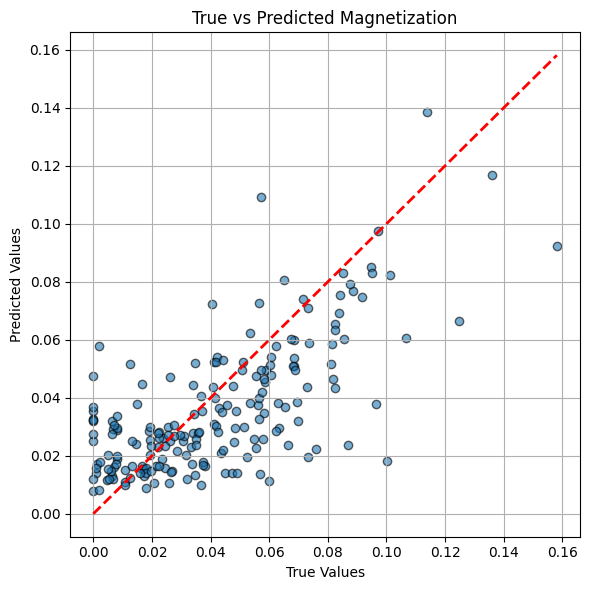

In [3]:
def make_safe_stratification_bins(y, min_per_bin=30, max_bins=10):
    for n_bins in range(max_bins, 1, -1):
        try:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
            y_binned = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()
            _, counts = np.unique(y_binned, return_counts=True)
            if np.min(counts) >= min_per_bin:
                print(f"✅ Using {n_bins} bins for stratification (min bin size: {np.min(counts)})")
                return y_binned
        except Exception:
            continue
    raise ValueError("❌ Could not bin targets adequately for stratification.")

dataset = CIFData(
    id_prop_path='my_new_data1/mn_fim.csv',
    magmom_path='my_new_data1/magmom.json',
    eigen_path='my_new_data1/eigenvalues_bulk.json',
    ofm_val_comp_path='my_new_data1/ofm.json'
)

# Extract all targets
targets = torch.stack([dataset[i][1] for i in range(len(dataset))]).numpy()
y_binned = make_safe_stratification_bins(targets)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

r2_scores, mae_scores, rmse_scores, cc_scores = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(targets)), y_binned), start=1):
    print(f"\n🔁 Fold {fold}/5")

    train_subset = Subset(dataset, train_idx)
    test_subset = Subset(dataset, test_idx)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=collate_pool)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=collate_pool)

    # Model init
    batch = next(iter(train_loader))
    (atom_fea, nbr_fea, nbr_idx, _), _ = batch
    model = CrystalGraphNet(atom_fea.shape[1], nbr_fea.shape[2])
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.1)

    # Early stopping parameters
    best_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    # 🔁 Training with early stopping
    for epoch in range(100):
        model.train()
        total_loss = 0
        for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in train_loader:
            optimizer.zero_grad()
            outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
            loss = criterion(outputs.view(-1), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}: Loss={avg_loss:.6f}, LR={scheduler.get_last_lr()[0]:.1e}")
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best model for evaluation
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pt"))

    # 🧪 Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in test_loader:
            outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
            y_true.extend(targets.view(-1).numpy())
            y_pred.extend(outputs.view(-1).numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    r2_scores.append(r2_score(y_true, y_pred))
    mae_scores.append(mean_absolute_error(y_true, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    cc_scores.append(pearsonr(y_true, y_pred)[0])

    print(f"\n📊 Fold {fold} Evaluation:")
    print(f"R²   : {r2_scores[-1]:.4f}")
    print(f"MAE  : {mae_scores[-1]:.4f}")
    print(f"RMSE : {rmse_scores[-1]:.4f}")
    print(f"CC   : {cc_scores[-1]:.4f}") 

print("\n📋 Final Stratified 5-Fold CV Summary:")
print(f"Avg R²   : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Avg MAE  : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Avg RMSE : {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Avg CC   : {np.mean(cc_scores):.4f} ± {np.std(cc_scores):.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)  # 1:1 line
plt.title(f'True vs Predicted Magnetization')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()

Training and Testing with Stratified 60-20-20 datasplit

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import matplotlib.pyplot as plt

# ===== Function to create stratification bins =====
def make_safe_stratification_bins(y, min_per_bin=30, max_bins=10):
    for n_bins in range(max_bins, 1, -1):
        try:
            discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
            y_binned = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()
            _, counts = np.unique(y_binned, return_counts=True)
            if np.min(counts) >= min_per_bin:
                print(f"✅ Using {n_bins} bins for stratification (min bin size: {np.min(counts)})")
                return y_binned
        except Exception:
            continue
    raise ValueError("❌ Could not bin targets adequately for stratification.")

# ===== Load dataset =====
dataset = CIFData(
    id_prop_path='my_new_data1/co_fm.csv',
    magmom_path='my_new_data1/magmom.json',
    eigen_path='my_new_data1/eigenvalues_bulk.json',
    ofm_val_comp_path='my_new_data1/ofm.json'
)

# Create stratification bins from targets
targets = torch.stack([dataset[i][1] for i in range(len(dataset))]).numpy()
y_binned = make_safe_stratification_bins(targets)

# ===== 60-20-20 stratified split =====
train_idx, temp_idx, _, temp_bins = train_test_split(
    np.arange(len(dataset)), y_binned,
    test_size=0.6, stratify=y_binned, random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_bins, random_state=42
)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# ===== DataLoaders =====
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32, shuffle=True, collate_fn=collate_pool)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=32, shuffle=False, collate_fn=collate_pool)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=32, shuffle=False, collate_fn=collate_pool)

# ===== Model init =====
batch = next(iter(train_loader))
(atom_fea, nbr_fea, nbr_idx, _), _ = batch
model = CrystalGraphNet(atom_fea.shape[1], nbr_fea.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)

# ===== Early stopping =====
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# ===== Training loop =====
for epoch in range(30):
    # Train
    model.train()
    total_loss = 0
    for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in train_loader:
        optimizer.zero_grad()
        outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
        loss = criterion(outputs.view(-1), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in val_loader:
            outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
            loss = criterion(outputs.view(-1), targets.view(-1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch}: Train={avg_train_loss:.6f}, Val={avg_val_loss:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# ===== Final Evaluation =====
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

def evaluate(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in loader:
            outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
            y_true.extend(targets.view(-1).numpy())
            y_pred.extend(outputs.view(-1).numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "CC": pearsonr(y_true, y_pred)[0]
    }

val_metrics = evaluate(val_loader)
test_metrics = evaluate(test_loader)

print("\n=== Final Results ===")
print(f"Validation -> R²: {val_metrics['R2']:.4f}, MAE: {val_metrics['MAE']:.4f}, RMSE: {val_metrics['RMSE']:.4f}, CC: {val_metrics['CC']:.4f}")
print(f"Test       -> R²: {test_metrics['R2']:.4f}, MAE: {test_metrics['MAE']:.4f}, RMSE: {test_metrics['RMSE']:.4f}, CC: {test_metrics['CC']:.4f}")

# ===== Scatter plot (Test set) =====
y_true, y_pred = [], []
with torch.no_grad():
    for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in test_loader:
        outputs = model(atom_fea.float(), nbr_fea.float(), nbr_idx.long(), crystal_atom_idx)
        y_true.extend(targets.view(-1).numpy())
        y_pred.extend(outputs.view(-1).numpy())

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
plt.title('True vs Predicted Magnetization (Test)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Using 10 bins for stratification (min bin size: 294)
Train: 1177, Val: 883, Test: 884
Epoch 0: Train=0.005253, Val=0.000643
Epoch 1: Train=0.000474, Val=0.000740
Epoch 2: Train=0.000382, Val=0.000310
Epoch 3: Train=0.000277, Val=0.001211
Epoch 4: Train=0.000240, Val=0.000309
Epoch 5: Train=0.000277, Val=0.000237
Epoch 6: Train=0.000298, Val=0.000418
Epoch 7: Train=0.000239, Val=0.000349


PCA , T-SNE Analysis

In [4]:
# ======================================================
# 1. Imports and setup
# ======================================================
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Subset

model.eval()

# ======================================================
# 2. Prepare dataset subset for analysis (speed)
# ======================================================
#subset_indices = np.arange(min(200, len(dataset)))  # analyze first 200 crystals
subset_indices = np.arange(len(dataset)) # analyze all crystals

analysis_dataset = Subset(dataset, subset_indices)
analysis_loader = DataLoader(analysis_dataset, batch_size=32, collate_fn=collate_pool, shuffle=False)

# ======================================================
# 3. Manual forward pass capturing layer outputs
# ======================================================
def get_all_layer_outputs(model, loader):
    """
    Runs the model manually layer-by-layer and captures features
    after each convolution for the entire dataset.
    """
    layer_outputs = {f"conv_{i+1}": [] for i in range(len(model.convs))}
    all_targets = []
    all_crystal_atom_idx = []

    with torch.no_grad():
        for (atom_fea, nbr_fea, nbr_idx, crystal_atom_idx), targets in loader:
            # --- Initial embedding ---
            x = model.embedding(atom_fea.float())

            # --- Capture after each convolution ---
            for i, conv in enumerate(model.convs):
                x = conv(x, nbr_fea.float(), nbr_idx.long())
                layer_outputs[f"conv_{i+1}"].append(x.cpu())

            # Collect targets and crystal indices
            all_targets.append(targets)
            all_crystal_atom_idx.extend(crystal_atom_idx)

    # Concatenate outputs across batches
    for key in layer_outputs:
        layer_outputs[key] = torch.cat(layer_outputs[key], dim=0)

    all_targets = torch.cat(all_targets).numpy()
    return layer_outputs, all_targets, all_crystal_atom_idx

layer_outputs, all_targets, all_crystal_atom_idx = get_all_layer_outputs(model, analysis_loader)

# ======================================================
# 4. Helper functions for pooling and plotting
# ======================================================
def pool_features(features, crystal_atom_idx):
    """Mean-pool node features to graph-level features."""
    pooled = []
    for idx in crystal_atom_idx:
        pooled.append(features[idx].mean(dim=0))
    return torch.stack(pooled)

def plot_and_save(features, labels, title, save_path):
    """Perform PCA and t-SNE and save both plots to disk."""
    # --- PCA ---
    pca = PCA(n_components=2)
    proj_pca = pca.fit_transform(features)
    plt.figure(figsize=(6,5))

# --- PCA ---
    scatter = plt.scatter(proj_pca[:,0], proj_pca[:,1], c=labels, cmap='viridis', s=25)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Magnetization', fontsize=16)

    plt.title(f"{title} (PCA)", fontsize=18)
    plt.xlabel("PC1", fontsize=16)
    plt.ylabel("PC2", fontsize=16)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()  # 🔥 prevent labels from being cut
    plt.savefig(f"{save_path}_PCA.png", dpi=300, bbox_inches="tight")
    plt.close()


# --- t-SNE ---
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    proj_tsne = tsne.fit_transform(features)
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(proj_tsne[:,0], proj_tsne[:,1], c=labels, cmap='coolwarm', s=25)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Magnetization', fontsize=16)

    plt.title(f"{title} (t-SNE)", fontsize=18)
    plt.xlabel("t-SNE 1", fontsize=16)
    plt.ylabel("t-SNE 2", fontsize=16)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    plt.tight_layout()  # adjust layout automatically
    plt.savefig(f"{save_path}_tSNE.png", dpi=300, bbox_inches="tight")
    plt.close()



# Create output directory
os.makedirs("feature_analysis_plots", exist_ok=True)

# ======================================================
# 5. Generate and save plots for each convolution layer
# ======================================================
for name, feat in layer_outputs.items():
    print(f"=== {name} ===")
    print(f"Feature shape (nodes): {feat.shape}")

    # --- Node-level labels (expand graph targets to nodes) ---
    node_labels = []
    for i, idx in enumerate(all_crystal_atom_idx):
        node_labels.extend([all_targets[i]] * len(idx))
    node_labels = np.array(node_labels)

    # Node-level plots
    plot_and_save(
        feat.numpy(), node_labels,
        title=f"{name} - Node Level",
        save_path=f"feature_analysis_plots/{name}_node"
    )

    # Graph-level pooled features
    pooled_feat = pool_features(feat, all_crystal_atom_idx)
    plot_and_save(
        pooled_feat.numpy(), all_targets,
        title=f"{name} - Graph Level",
        save_path=f"feature_analysis_plots/{name}_graph"
    )

print("✅ All PCA and t-SNE plots saved in 'feature_analysis_plots/' folder.")


=== conv_1 ===
Feature shape (nodes): torch.Size([24015, 64])
=== conv_2 ===
Feature shape (nodes): torch.Size([24015, 64])
=== conv_3 ===
Feature shape (nodes): torch.Size([24015, 64])
=== conv_4 ===
Feature shape (nodes): torch.Size([24015, 64])
✅ All PCA and t-SNE plots saved in 'feature_analysis_plots/' folder.


In [5]:
# ---------------------------
# Replace-from-here: Helper + plotting (drop-in replacement)
# ---------------------------
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os

cmap_name = 'viridis'    # consistent colormap for PCA and t-SNE
scatter_size = 25
tsne_perplexity = 30
tsne_random_state = 42

# pool helper unchanged
def pool_features(features, crystal_atom_idx):
    """Mean-pool node features to graph-level features."""
    pooled = []
    for idx in crystal_atom_idx:
        pooled.append(features[idx].mean(dim=0))
    return torch.stack(pooled)

# --- Prepare node and graph labels once (expand graph targets to nodes) ---
# all_crystal_atom_idx is a list where each element is an index array/tensor for one crystal
node_labels = []
for i, idx in enumerate(all_crystal_atom_idx):
    # idx may be tensor or array-like; len(idx) gives number of atoms in that crystal
    node_labels.extend([all_targets[i]] * len(idx))
node_labels = np.array(node_labels)
graph_labels = all_targets  # shape (n_graphs, )

# --- Compute projections for all layers first (so we can compute global axis limits) ---
proj_data = {
    'node': {'pca': {}, 'tsne': {}},    # proj_data['node']['pca'][layer_name] = np.array([... ,2])
    'graph': {'pca': {}, 'tsne': {}}
}

print("Computing PCA projections for all layers...")
for name, feat in layer_outputs.items():
    # feat: (total_nodes, D) where nodes are concatenated across dataset in same order as node_labels
    feat_np = feat.numpy()
    # Node-level PCA
    pca = PCA(n_components=2)
    proj_pca_node = pca.fit_transform(feat_np)
    proj_data['node']['pca'][name] = proj_pca_node

    # Graph-level pooled PCA
    pooled_feat = pool_features(feat, all_crystal_atom_idx).numpy()
    pca_g = PCA(n_components=2)
    proj_pca_graph = pca_g.fit_transform(pooled_feat)
    proj_data['graph']['pca'][name] = proj_pca_graph

print("Computing t-SNE projections for all layers (this may take time)...")
for name, feat in layer_outputs.items():
    feat_np = feat.numpy()
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=tsne_random_state, init='pca')
    proj_tsne_node = tsne.fit_transform(feat_np)
    proj_data['node']['tsne'][name] = proj_tsne_node

    pooled_feat = pool_features(feat, all_crystal_atom_idx).numpy()
    tsne_g = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=tsne_random_state, init='pca')
    proj_tsne_graph = tsne_g.fit_transform(pooled_feat)
    proj_data['graph']['tsne'][name] = proj_tsne_graph

# --- Compute global axis ranges per projection type so all layers share same axes ---
def global_limits(list_of_arrays, margin=0.05):
    # list_of_arrays: list of (N,2) arrays
    if not list_of_arrays:
        return (-1,1,-1,1)
    xs = np.concatenate([a[:,0] for a in list_of_arrays])
    ys = np.concatenate([a[:,1] for a in list_of_arrays])
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    # add margin
    xpad = (xmax - xmin) * margin if xmax>xmin else 1.0
    ypad = (ymax - ymin) * margin if ymax>ymin else 1.0
    return xmin - xpad, xmax + xpad, ymin - ypad, ymax + ypad

node_pca_limits = global_limits(list(proj_data['node']['pca'].values()))
node_tsne_limits = global_limits(list(proj_data['node']['tsne'].values()))
graph_pca_limits = global_limits(list(proj_data['graph']['pca'].values()))
graph_tsne_limits = global_limits(list(proj_data['graph']['tsne'].values()))

# --- Color normalization (same for all plots) ---
vmin = float(min(node_labels.min(), graph_labels.min()))
vmax = float(max(node_labels.max(), graph_labels.max()))

Computing PCA projections for all layers...
Computing t-SNE projections for all layers (this may take time)...


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
fig_dir = "feature_analysis_plots"

os.makedirs(fig_dir, exist_ok=True)

def save_2x2_combined(panel_arrays, labels, title, fname_base,
                      limits, cmap='viridis', vmin=None, vmax=None,
                      marker_size=18, fontsize=10, suptitle_size=12):
    """
    Create a single 2x2 figure from 4 (N,2) arrays with one shared colorbar.
    panel_arrays: list of four (N,2) numpy arrays in display order:
                  [conv_1, conv_2, conv_3, conv_4]
    labels: color values array (length matches rows in each panel)
    limits: (xmin, xmax, ymin, ymax) - applied to all subplots
    fname_base: base path without extension; saves both .pdf and .png
    """
    assert len(panel_arrays) == 4, "Expect exactly 4 panels"
    fig, axes = plt.subplots(2, 2, figsize=(8.5, 7))   # good size for a single-column page figure
    axes = axes.ravel()

    # Plot each panel
    for ax, arr, lname in zip(axes, panel_arrays, layer_names):
        sc = ax.scatter(arr[:,0], arr[:,1], c=labels, cmap=cmap, s=marker_size,
                        vmin=vmin, vmax=vmax, edgecolors='none')
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.set_title(lname, fontsize=fontsize)
        ax.tick_params(labelsize=fontsize-1)

    # Shared axis labels (place in lower-left subplot)
    axes[2].set_xlabel('Dim 1', fontsize=fontsize)
    axes[2].set_ylabel('Dim 2', fontsize=fontsize)

    # Layout: reduced margins, space for single colorbar on right
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])  # leave room on right for colorbar and top for suptitle
    cbar_ax = fig.add_axes([0.90, 0.15, 0.025, 0.7])  # [left, bottom, width, height] in figure coords
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Magnetization', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize-1)

    fig.suptitle(title, fontsize=suptitle_size)
    # Save high-quality PDF + PNG for paper
    fig.savefig(fname_base + '.pdf', dpi=300, bbox_inches='tight')
    fig.savefig(fname_base + '.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

# ---------- Prepare arrays & limits and call function for four figures ----------

# ensure conv ordering conv_1..conv_4
layer_names = sorted(list(layer_outputs.keys()), key=lambda s: int(s.split('_')[-1]))

# Node PCA
node_pca_panels = [proj_data['node']['pca'][name] for name in layer_names]
save_2x2_combined(node_pca_panels, node_labels,
                  title="Node-level PCA (conv 1–4)",
                  fname_base=os.path.join(fig_dir, "combined_node_PCA_conv1-4"),
                  limits=node_pca_limits, cmap='viridis', vmin=vmin, vmax=vmax)

# Graph PCA
graph_pca_panels = [proj_data['graph']['pca'][name] for name in layer_names]
save_2x2_combined(graph_pca_panels, graph_labels,
                  title="Graph-level PCA (conv 1–4)",
                  fname_base=os.path.join(fig_dir, "combined_graph_PCA_conv1-4"),
                  limits=graph_pca_limits, cmap='viridis', vmin=vmin, vmax=vmax)

# Node t-SNE
node_tsne_panels = [proj_data['node']['tsne'][name] for name in layer_names]
save_2x2_combined(node_tsne_panels, node_labels,
                  title="Node-level t-SNE (conv 1–4)",
                  fname_base=os.path.join(fig_dir, "combined_node_tSNE_conv1-4"),
                  limits=node_tsne_limits, cmap='viridis', vmin=vmin, vmax=vmax)

# Graph t-SNE
graph_tsne_panels = [proj_data['graph']['tsne'][name] for name in layer_names]
save_2x2_combined(graph_tsne_panels, graph_labels,
                  title="Graph-level t-SNE (conv 1–4)",
                  fname_base=os.path.join(fig_dir, "combined_graph_tSNE_conv1-4"),
                  limits=graph_tsne_limits, cmap='viridis', vmin=vmin, vmax=vmax)

print("Saved merged 2x2 figures (PDF + PNG) to:", fig_dir)


Saved merged 2x2 figures (PDF + PNG) to: feature_analysis_plots
